# Project: Rating Prediction on Amazon Book Review

Group 3_Amazon

In [ ]:
# install.packages('tm')
# install.packages('wordcloud')
# install.packages("wordcloud2")
# install.packages("textstem")
# install.packages("caret")
# install.packages("e1071")
# install.packages("klaR")
# install.packages("kernlab")
# install.packages("rpartScore")

library(dplyr)
library(tidyr)
library(ggplot2)
library(tm)
library(wordcloud)
library(wordcloud2)
library(textstem)
library(caret)
library(klaR)
library(kernlab)
library(rpartScore)

SEED = 0

In [ ]:
link_amazon <- "https://drive.google.com/file/d/1LAfPcP0aV2MjmCU8pQ_f-w29-c3LQ6ko/view?usp=sharing"
id_amazon <- sub(".+/d/(.+)/view.+", "\\1", link_amazon)
system(paste("gdown --id", id_amazon))

In [ ]:
amazon <- read.csv("ds_book_review.csv")

In [ ]:
summary(amazon)

     stars         comment            book_url        
 Min.   :1.000   Length:20647       Length:20647      
 1st Qu.:4.000   Class :character   Class :character  
 Median :5.000   Mode  :character   Mode  :character  
 Mean   :4.309                                        
 3rd Qu.:5.000                                        
 Max.   :5.000                                        

In [ ]:
missing_comment <- sum(amazon$comment == "")
total <- length(amazon$comment)
missing_url <- sum(is.na(amazon$book_url))
unique_url <- length(unique(amazon$book_url))
print(paste0("Missing Comment: ", missing_comment, "/", total))
print(paste0("Missing Book URL: ", missing_url, "/", total))
print(paste0("Unique Book URL: ", unique_url, "/", total))

[1] "Missing Comment: 612/20647"
[1] "Missing Book URL: 0/20647"
[1] "Unique Book URL: 836/20647"


In [ ]:
amazon$stars <- as.factor(amazon$stars)
amazon$stars <- ordered(amazon$stars, levels = c("1", "2", "3", "4", "5"))
amazon <- subset(amazon, comment != "")

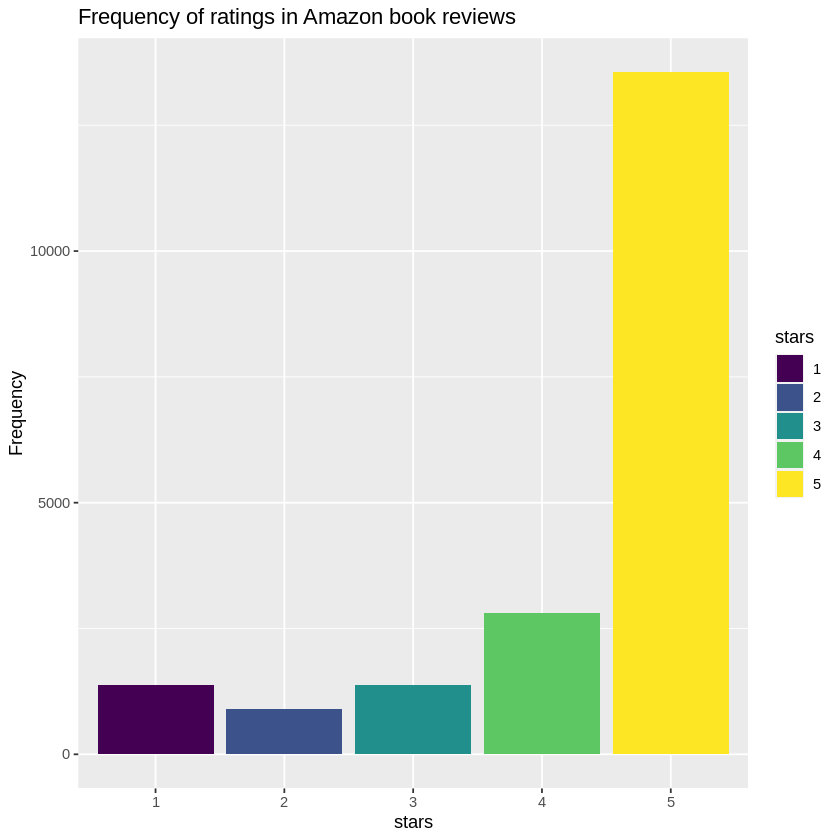

In [ ]:
amazon %>%
  ggplot(aes(x=stars, y=frequency(stars), fill=stars)) +
  geom_col() +
  ggtitle('Frequency of ratings in Amazon book reviews') +
  ylab('Frequency')

## NLP

In [ ]:
amazon_final <- amazon$comment %>%
  iconv() %>% 
  VectorSource() %>%
  Corpus() %>% 
  tm_map(tolower) %>%
  tm_map(removePunctuation) %>%
  tm_map(removeNumbers) %>%
  tm_map(removeWords, stopwords("english")) %>%
  tm_map(stripWhitespace) %>%
  tm_map(lemmatize_strings)

Warning message in tm_map.SimpleCorpus(., tolower):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., removePunctuation):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., removeNumbers):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., removeWords, stopwords("english")):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., stripWhitespace):
“transformation drops documents”
Warning message in tm_map.SimpleCorpus(., lemmatize_strings):
“transformation drops documents”


In [ ]:
inspect(amazon_final %>% head())

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 6

[1] let say outset review respect author sheer guile try attack phd level topic single book sw engineer last year engineer degree do research gas image segmentation many year ago find book challengingwhen college joke comp sci really just apply math wasnt really funny goshdarned true doubly deal datum science ai ml fancy word apply statisticsso book give background various topic stat probability theory linear algebra program touch topic calculus youre unfamiliar thing will able learn one book just muchthe author leave lot breadcrumb follow youre strong subject ive mention plan read book recommend onlineafter book solid tour datum science surprisingly theres material aiml good do criticism like equation alongside code know equation scare people datum sciencetldr seriousminded book serious people arent easy answer great education
[2] capitalism good read book nearby bookstore like reviewer

In [ ]:
dtm <- amazon_final %>%
  DocumentTermMatrix() %>%
  removeSparseTerms(sparse = 0.9) %>%
  as.matrix()
dtm <- dtm[rowSums(dtm[])>0,]
dtm[1:5, 1:5]

,author,book,datum,easy,find
1,2,7,3,1,1
2,2,5,1,0,0
3,0,3,1,0,0
4,0,3,4,0,0
5,0,1,1,1,1


In [ ]:
dim(dtm)

[1] 18893    36

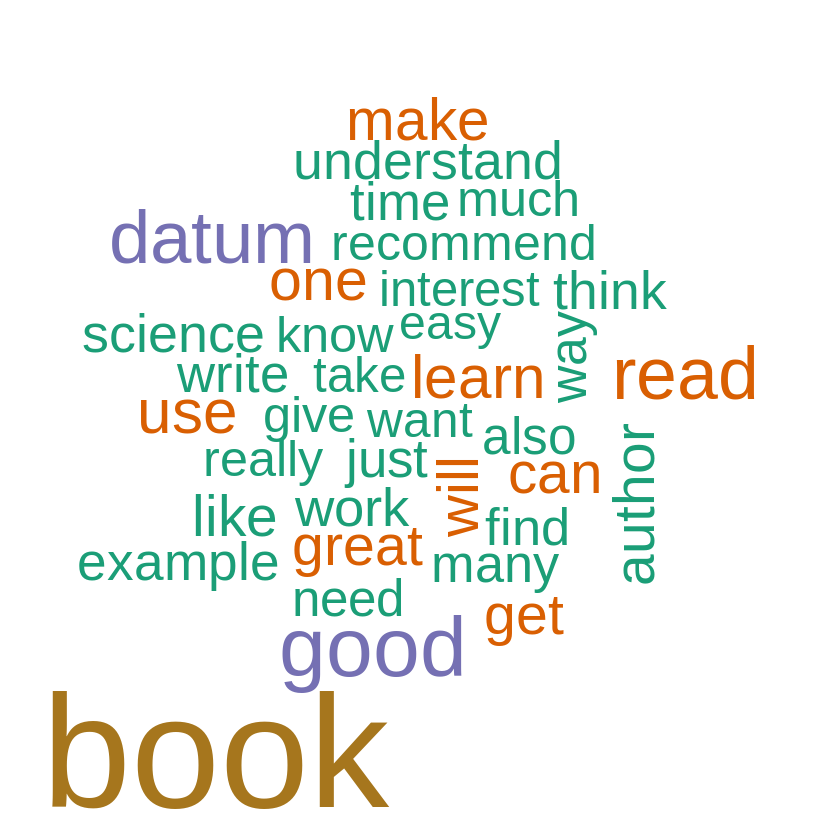

In [ ]:
w <- dtm %>%
  colSums() %>%
  sort(decreasing = T)
word_counts <- data.frame(word = names(w), freq = w)
set.seed(SEED)
wordcloud(names(w), freq = w, max.words = 50, random.order = T, min.freq = 5, colors = brewer.pal(7, "Dark2"), scale = c(8, 2))

In [ ]:
dtm <- amazon_final %>%
  DocumentTermMatrix(control = list(weighting = weightTfIdf)) %>%
  removeSparseTerms(sparse = 0.9) %>%
  as.matrix()
dtm <- dtm[rowSums(dtm[])>0,]
dtm[1:5, 1:5]

Warning message in TermDocumentMatrix.SimpleCorpus(x, control):
“custom functions are ignored”
Warning message in weighting(x):
“empty document(s): 3305 4096 4648 7138 9835 10896 11701 12084 14118 14704 15177 15676 18036 18225”


,author,book,datum,easy,find
1,0.04446209,0.02820910,0.05645473,0.02733672,0.02412251
2,0.05863133,0.02657058,0.02481527,0.00000000,0.00000000
3,0.00000000,0.04145011,0.06451969,0.00000000,0.00000000
4,0.00000000,0.02198112,0.13685995,0.00000000,0.00000000
5,0.00000000,0.01179475,0.05507778,0.08000991,0.07060246


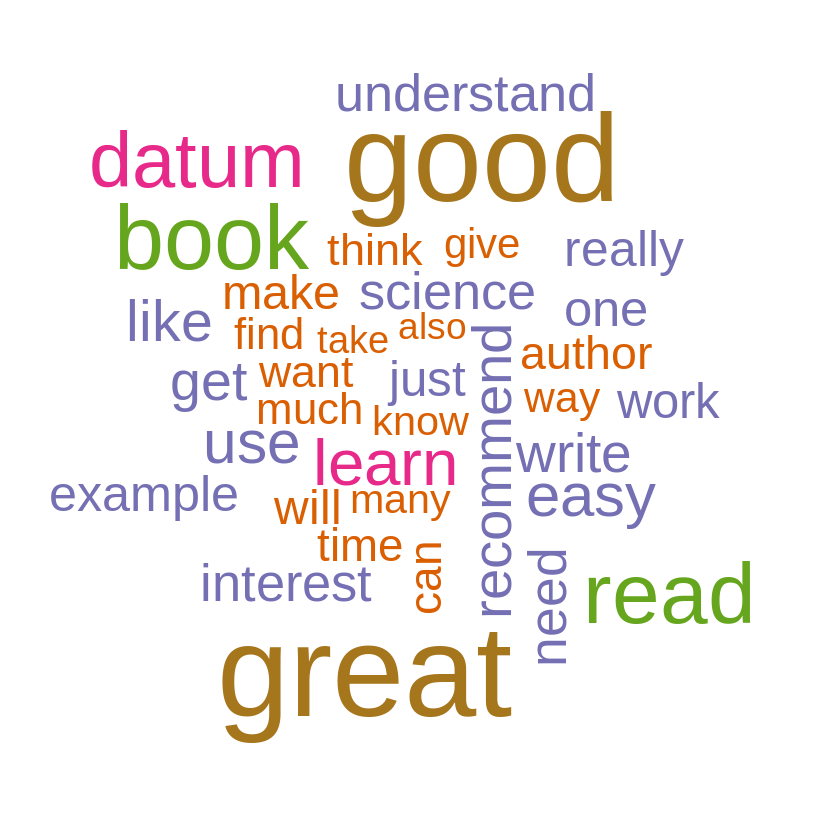

In [ ]:
w <- dtm %>%
  colSums() %>%
  sort(decreasing = T)
word_counts <- data.frame(word = names(w), freq = w)
set.seed(SEED)
wordcloud(names(w), freq = w, max.words = 50, random.order = T, min.freq = 5, colors = brewer.pal(7, "Dark2"), scale = c(6.5, 0.8))

## Rating Prediction

In [ ]:
dim(dtm)

[1] 18893    36

In [ ]:
dim(amazon)

[1] 20035     3

In [ ]:
rating <- amazon$stars[dtm %>% rownames() %>% as.integer()]
amazon1 <- bind_cols(dtm, rating = rating, id = NULL)
amazon1 %>% head()

author,book,datum,easy,find,give,good,great,just,know,⋯,write,need,example,interest,understand,can,much,also,work,rating
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<ord>
0.04446209,0.02820910,0.05645473,0.02733672,0.02412251,0.02570368,0.01108829,0.01907062,0.04735144,0.02622376,⋯,0.00000000,0,0,0,0,0,0,0,0,5
0.05863133,0.02657058,0.02481527,0.00000000,0.00000000,0.03389496,0.01462192,0.02514808,0.00000000,0.03458079,⋯,0.00000000,0,0,0,0,0,0,0,0,1
0.00000000,0.04145011,0.06451969,0.00000000,0.00000000,0.08812690,0.00000000,0.06538500,0.00000000,0.00000000,⋯,0.00000000,0,0,0,0,0,0,0,0,5
0.00000000,0.02198112,0.13685995,0.00000000,0.00000000,0.04673396,0.02016053,0.00000000,0.00000000,0.00000000,⋯,0.04216569,0,0,0,0,0,0,0,0,5
0.00000000,0.01179475,0.05507778,0.08000991,0.07060246,0.00000000,0.00000000,0.00000000,0.06929479,0.07675248,⋯,0.06787648,0,0,0,0,0,0,0,0,4
0.00000000,0.06307625,0.09818214,0.00000000,0.00000000,0.00000000,0.00000000,0.09949891,0.00000000,0.00000000,⋯,0.00000000,0,0,0,0,0,0,0,0,5


In [ ]:
set.seed(SEED)
sample <- sample.int(n = nrow(amazon1), size = floor(.75*nrow(amazon1)), replace = F)
train_set <- amazon1[sample, ]
test_set  <- amazon1[-sample, ]
trControl <- trainControl(method = "cv", number = 5)


### KNN

In [ ]:
tune_grid <- expand.grid(k = seq(1, 30, 2))
knn <- train(rating ~ .,
             method     = "knn",
             trControl  = trControl,
             tuneGrid   = tune_grid,
             metric     = "Accuracy",
             data       = train_set)
knn

k-Nearest Neighbors 

14169 samples
   36 predictor
    5 classes: '1', '2', '3', '4', '5' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 11334, 11337, 11334, 11336, 11335 
Resampling results across tuning parameters:

  k   Accuracy   Kappa      
   1  0.5329948  0.078397769
   3  0.5754110  0.060969330
   5  0.6105590  0.046529966
   7  0.6381550  0.047238091
   9  0.6499405  0.039438668
  11  0.6581269  0.032462828
  13  0.6634198  0.027246953
  15  0.6662433  0.019735944
  17  0.6686431  0.014450596
  19  0.6704777  0.013093914
  21  0.6719600  0.010639460
  23  0.6725247  0.008465846
  25  0.6736537  0.008261370
  27  0.6745712  0.008601102
  29  0.6745713  0.007141161

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 29.

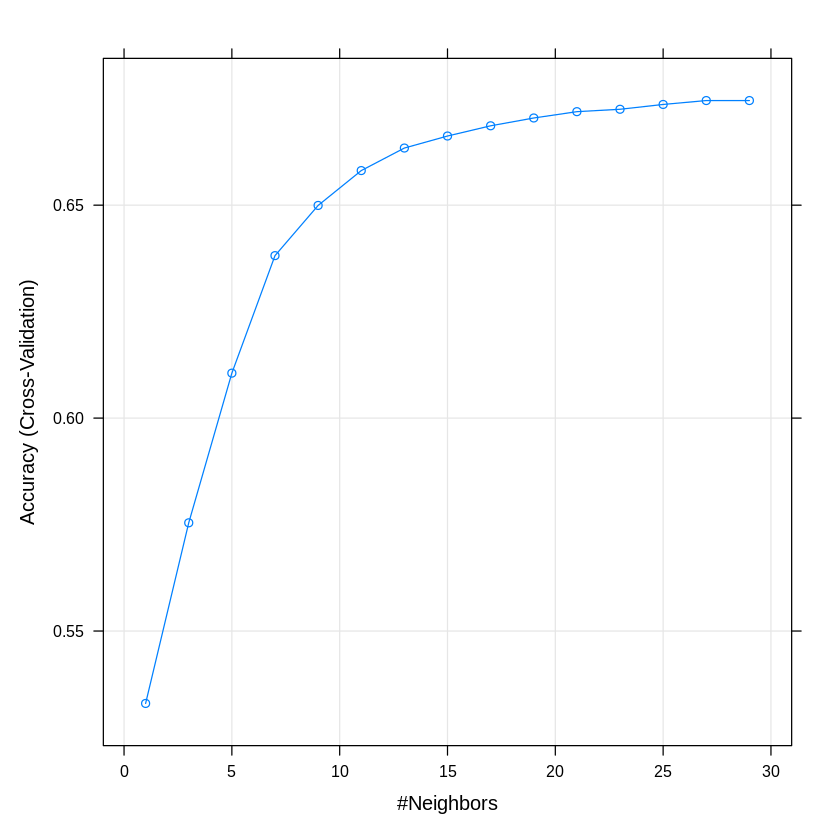

In [ ]:
plot(knn)

In [ ]:
test_pred <- predict(knn,subset(test_set, select = -rating))
confusionMatrix(test_pred, test_set$rating)

Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4    5
         1    4    2    1    1    2
         2    0    0    0    0    2
         3    0    0    0    1    1
         4    2    2    0    5    2
         5  301  218  341  650 3189

Overall Statistics
                                          
               Accuracy : 0.677           
                 95% CI : (0.6634, 0.6903)
    No Information Rate : 0.6765          
    P-Value [Acc > NIR] : 0.4821          
                                          
                  Kappa : 0.0107          
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                      Class: 1  Class: 2  Class: 3 Class: 4 Class: 5
Sensitivity          0.0130293 0.0000000 0.0000000 0.007610  0.99781
Specificity          0.9986416 0.9995558 0.9995436 0.998525  0.01178
Pos Pred Value       0.4000000 0.0000000 0.0000000 0.454545  0.67866
Neg Pred Value       0.93

### Decision Tree

In [ ]:
tune_grid <- expand.grid(cp = c(0, 1), split = c("abs", "quad"), prune = c("mc", "mr"))
dtree <- train(rating ~ .,
              method     = "rpartScore",
              trControl  = trControl,
              tuneGrid   = tune_grid,
              metric     = "Accuracy",
              data       = train_set)
dtree

CART or Ordinal Responses 

14169 samples
   36 predictor
    5 classes: '1', '2', '3', '4', '5' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 11337, 11335, 11335, 11334, 11335 
Resampling results across tuning parameters:

  cp  split  prune  Accuracy   Kappa     
  0   abs    mc     0.5716687  0.06316868
  0   abs    mr     0.6174758  0.05663217
  0   quad   mc     0.5689867  0.06076069
  0   quad   mr     0.6313778  0.05422295
  1   abs    mc     0.6746419  0.00000000
  1   abs    mr     0.6746419  0.00000000
  1   quad   mc     0.6746419  0.00000000
  1   quad   mr     0.6746419  0.00000000

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were cp = 1, split = abs and prune = mc.

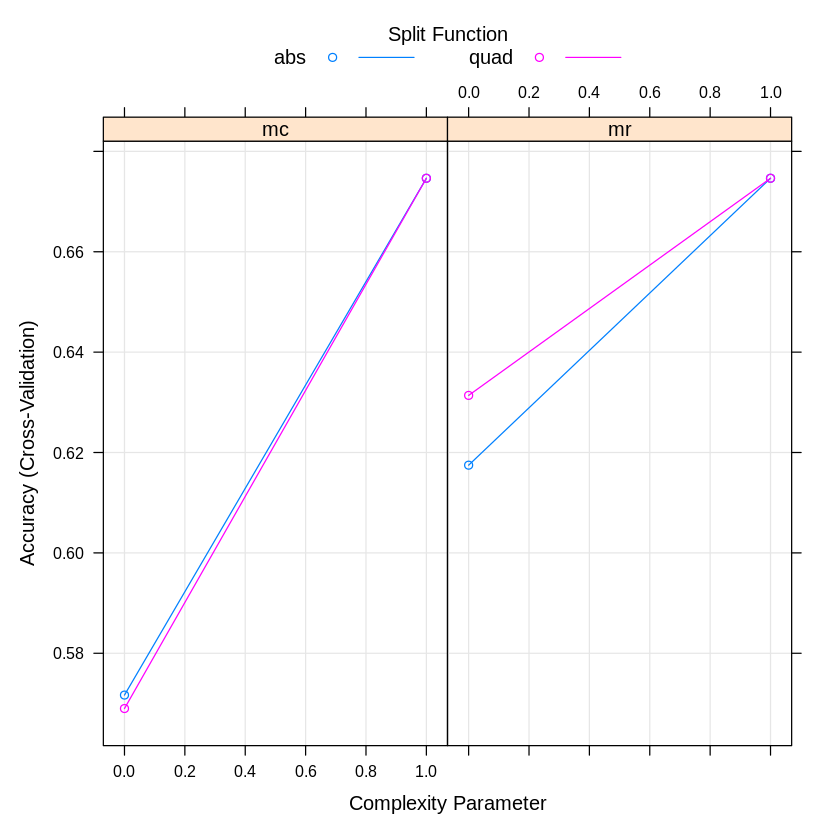

In [ ]:
plot(dtree)

In [ ]:
test_pred <- predict(dtree,subset(test_set, select = -rating))
confusionMatrix(test_pred, test_set$rating)

Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4    5
         1    0    0    0    0    0
         2    0    0    0    0    0
         3    0    0    0    0    0
         4    0    0    0    0    0
         5  307  222  342  657 3196

Overall Statistics
                                         
               Accuracy : 0.6765         
                 95% CI : (0.663, 0.6899)
    No Information Rate : 0.6765         
    P-Value [Acc > NIR] : 0.5069         
                                         
                  Kappa : 0              
                                         
 Mcnemar's Test P-Value : NA             

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity           0.00000  0.00000   0.0000   0.0000   1.0000
Specificity           1.00000  1.00000   1.0000   1.0000   0.0000
Pos Pred Value            NaN      NaN      NaN      NaN   0.6765
Neg Pred Value        0.93501  0.95301   0.927

### Naive Bayes

In [ ]:
tune_grid <- expand.grid(fL = 0, usekernel = TRUE, adjust = seq(0.1, 1, 0.1))
nb <- train(rating ~ .,
            method     = "nb",
            trControl  = trControl,
            tuneGrid   = tune_grid,
            metric     = "Accuracy",
            data       = train_set)
nb

Naive Bayes 

14169 samples
   36 predictor
    5 classes: '1', '2', '3', '4', '5' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 11334, 11336, 11334, 11336, 11336 
Resampling results across tuning parameters:

  adjust  Accuracy   Kappa     
  0.1     0.6269939  0.02214437
  0.2     0.5780062  0.03913294
  0.3     0.6327168  0.02629923
  0.4     0.6404109  0.02153592
  0.5     0.6429516  0.02004653
  0.6     0.6414694  0.01966833
  0.7     0.6441520  0.01564711
  0.8     0.6430929  0.01741895
  0.9     0.6442218  0.01643420
  1.0     0.6444332  0.01584141

Tuning parameter 'fL' was held constant at a value of 0
Tuning
 parameter 'usekernel' was held constant at a value of TRUE
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were fL = 0, usekernel = TRUE and adjust
 = 1.

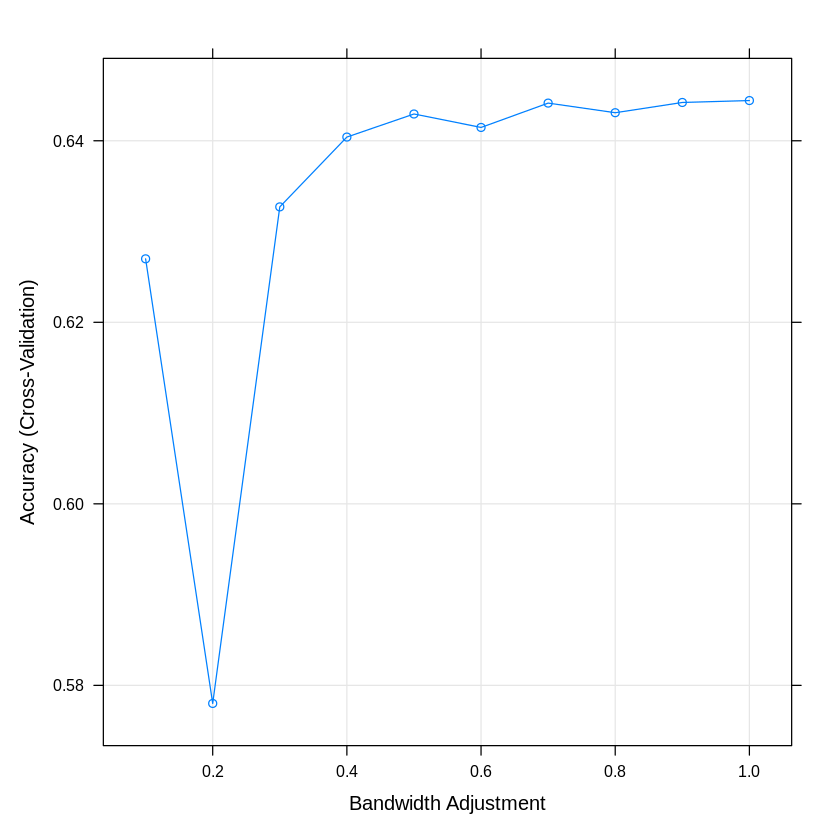

In [ ]:
plot(nb)

In [ ]:
test_pred <- predict(nb,subset(test_set, select = -rating))
confusionMatrix(test_pred, test_set$rating)

Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4    5
         1    5    5   10   14   32
         2    1    3    3    8   30
         3    2    2    6    8   35
         4    1    1    3    8   30
         5  298  211  320  619 3069

Overall Statistics
                                          
               Accuracy : 0.6543          
                 95% CI : (0.6406, 0.6679)
    No Information Rate : 0.6765          
    P-Value [Acc > NIR] : 0.9995          
                                          
                  Kappa : 0.0114          
                                          
 Mcnemar's Test P-Value : <2e-16          

Statistics by Class:

                     Class: 1  Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity          0.016287 0.0135135  0.01754 0.012177  0.96026
Specificity          0.986190 0.9906708  0.98927 0.991394  0.05236
Pos Pred Value       0.075758 0.0666667  0.11321 0.186047  0.67943
Neg Pred Value       0.935165 0.9

### SVM

In [ ]:
tune_grid <- expand.grid(C = 10^c(-1:1), sigma=10^c(-1:1))
svm <- train(rating ~ .,
            method     = "svmRadial",
            trControl  = trControl,
            tuneGrid   = tune_grid,
            metric     = "Accuracy",
            data       = train_set)
svm

Support Vector Machines with Radial Basis Function Kernel 

14169 samples
   36 predictor
    5 classes: '1', '2', '3', '4', '5' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 11336, 11334, 11334, 11338, 11334 
Resampling results across tuning parameters:

  C     sigma  Accuracy   Kappa     
   0.1   0.1   0.6746420  0.00000000
   0.1   1.0   0.6746420  0.00000000
   0.1  10.0   0.6746420  0.00000000
   1.0   0.1   0.6745011  0.00871323
   1.0   1.0   0.6781001  0.04579633
   1.0  10.0   0.6772536  0.04980270
  10.0   0.1   0.6351894  0.07462403
  10.0   1.0   0.6664554  0.05911545
  10.0  10.0   0.6742897  0.05250561

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 1 and C = 1.

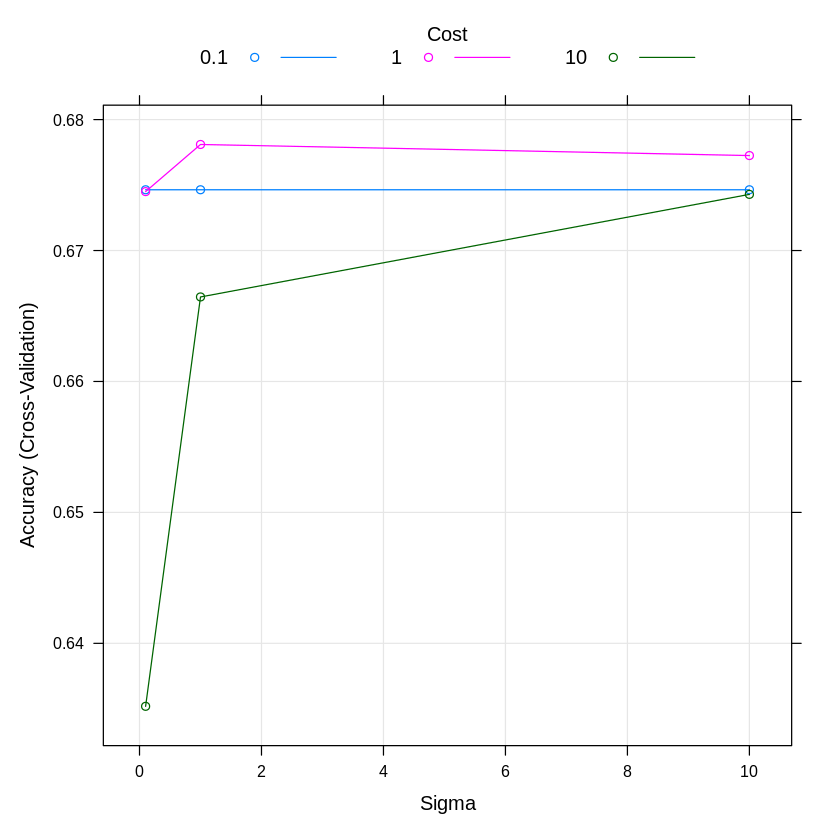

In [ ]:
plot(svm)

In [ ]:
test_pred <- predict(svm,subset(test_set, select = -rating))
confusionMatrix(test_pred, test_set$rating)

Confusion Matrix and Statistics

          Reference
Prediction    1    2    3    4    5
         1   10    3    1    0   13
         2    1    8    1    0    2
         3    2    0   14    1    4
         4    1    2    1   24   18
         5  293  209  325  632 3159

Overall Statistics
                                          
               Accuracy : 0.6806          
                 95% CI : (0.6671, 0.6939)
    No Information Rate : 0.6765          
    P-Value [Acc > NIR] : 0.2829          
                                          
                  Kappa : 0.0506          
                                          
 Mcnemar's Test P-Value : <2e-16          

Statistics by Class:

                     Class: 1 Class: 2 Class: 3 Class: 4 Class: 5
Sensitivity          0.032573 0.036036 0.040936 0.036530  0.98842
Specificity          0.996151 0.999112 0.998403 0.994591  0.04516
Pos Pred Value       0.370370 0.666667 0.666667 0.521739  0.68406
Neg Pred Value       0.936768 0.95458

In [ ]:
model <- c("KNN", "Decision Tree", "Naive Bayes", "Radial SVM")
validation <- c(0.6745713, 0.6746419, 0.6463424, 0.6781001)
test <- c(0.677, 0.6765, 0.6494, 0.6806)
results <- data.frame(model, validation, test) %>%
  gather("accuracy", "score", -model)
results$accuracy <- factor(results$accuracy, levels = c("validation", "test"))

## Comparing Results

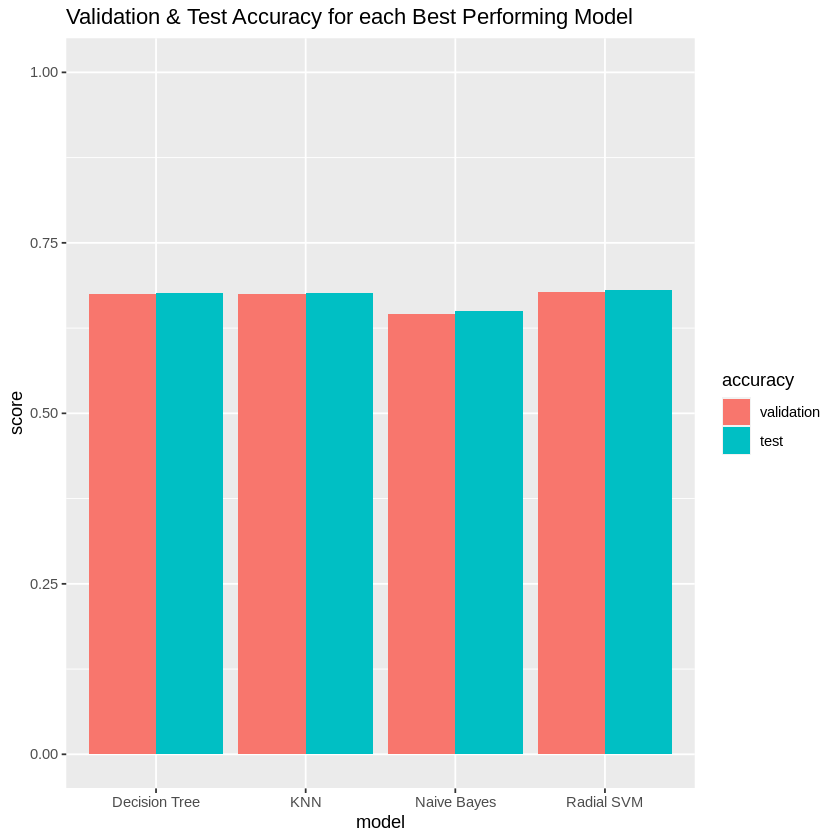

In [ ]:
ggplot(results, aes(x = model, y = score, fill = accuracy)) +
  geom_col(position = "dodge") +
  ggtitle("Validation & Test Accuracy for each Best Performing Model") +
  ylim(c(0,1))